In [1]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.tsa as sm
from scipy import signal
from scipy.stats import yeojohnson
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.var_model import VAR
from tqdm import tqdm_notebook

In /home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
df = pd.read_csv('../data/all_stocks_5yr.csv')

In [3]:
df

date   open   high    low  close    volume Name
0       2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]

## 1. Variables

In [4]:
predictors = ['AAPL', 'CVX', 'JPM']
targets = ['CSCO', 'DUK', 'GS']

## 2. Analysis of stationarity

Dickey-Fuller test: p = 0.8822295193799579
Dickey-Fuller test: p = 0.39241455478438636
Dickey-Fuller test: p = 0.9914682651792028


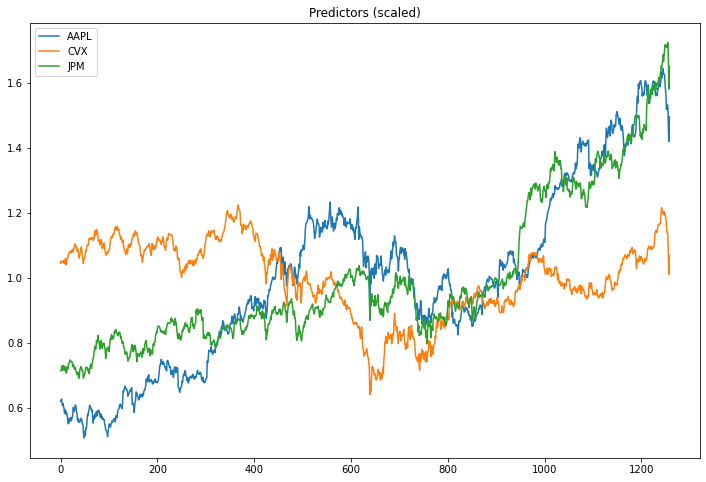

In [5]:
plt.figure(figsize=(12, 8))

for pred in predictors:
    data_plot = df[df['Name'] == pred]['open'].to_numpy()
    print(f'Dickey-Fuller test: p = {adfuller(data_plot)[1]}')
    plt.plot(data_plot / data_plot.mean(axis=0), label=pred)

plt.title('Predictors (scaled)')
plt.legend()
plt.show()

In [6]:
plt.figure(figsize=(12, 8))

for target in targets:
    data_plot = df[df['Name'] == target]['open'].to_numpy()
    print(f'Dickey-Fuller test: p = {sm.stattools.adfuller(data_plot)[1]}')
    plt.plot(data_plot / data_plot.mean(axis=0), label=target)
    
plt.title('Targets (scaled)')
plt.legend()
plt.show()

Dickey-Fuller test: p = 0.8903689730375304
Dickey-Fuller test: p = 0.11914549955283787
Dickey-Fuller test: p = 0.8214311319878509


### As we can see, most of the cosidered processes are non-stationary in terms of both mean values and variations (which is also confirmed by stationarity test), hence we substract its trends using high-pass filtering.

Dickey-Fuller test: p = 7.104818130002443e-17
Dickey-Fuller test: p = 3.460886399566523e-17
Dickey-Fuller test: p = 1.6163523958317822e-17


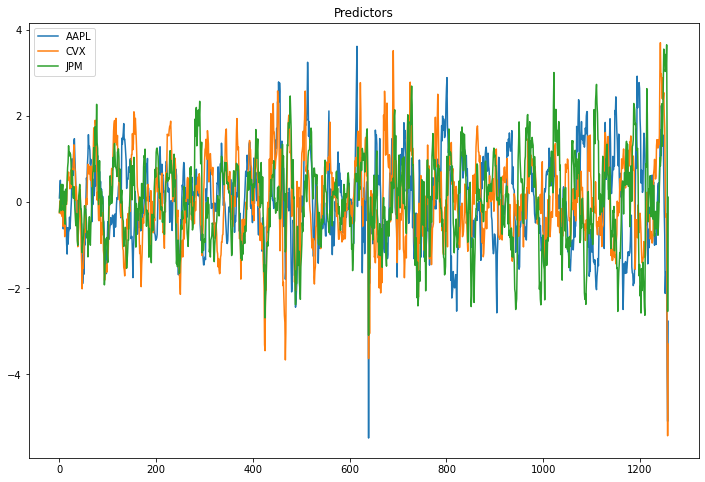

In [7]:
plt.figure(figsize=(12, 8))
b_norm, a_norm = signal.butter(3, 0.025)

data_predictors = []
for pred in predictors:
    data_plot = df[df['Name'] == pred]['open'].to_numpy()
    data_filtered = signal.filtfilt(b_norm, a_norm, data_plot)
    data_plot = data_plot - data_filtered
    data_plot, _ = yeojohnson(data_plot)
    data_plot = data_plot / data_plot.std(axis=0)
    data_predictors.append(data_plot)
    print(f'Dickey-Fuller test: p = {sm.stattools.adfuller(data_plot)[1]}')
    plt.plot(data_plot, label=pred)

data_predictors = np.array(data_predictors)
plt.title('Predictors')
plt.legend()
plt.show()

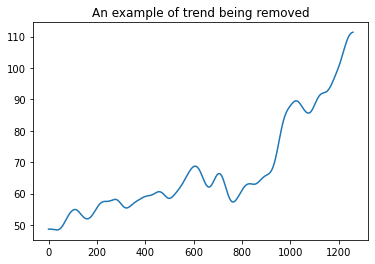

In [8]:
plt.title('An example of trend being removed')
plt.plot(data_filtered)
plt.show()

Dickey-Fuller test: p = 1.5210835956394238e-19
Dickey-Fuller test: p = 1.4113273861652064e-15
Dickey-Fuller test: p = 6.290888512890443e-17


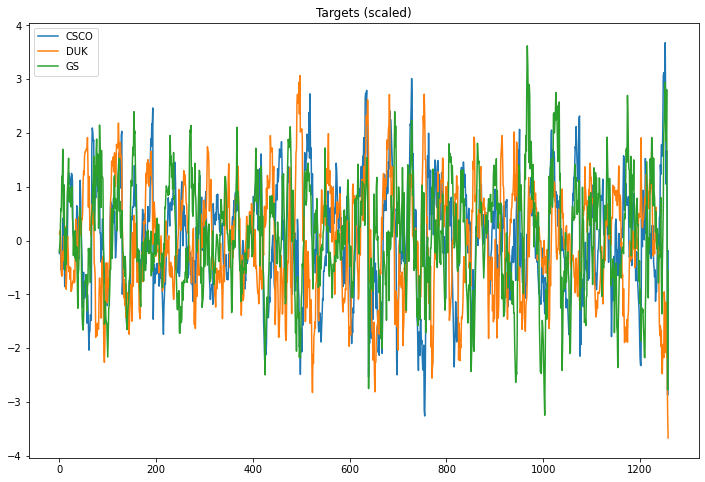

In [9]:
plt.figure(figsize=(12, 8))

data_targets = []
for target in targets:
    data_plot = df[df['Name'] == target]['open'].to_numpy()
    data_filtered = signal.filtfilt(b_norm, a_norm, data_plot)
    data_plot = data_plot - data_filtered
    data_plot, _ = yeojohnson(data_plot)
    data_plot = data_plot / data_plot.std(axis=0)
    data_targets.append(data_plot)
    print(f'Dickey-Fuller test: p = {sm.stattools.adfuller(data_plot)[1]}')
    plt.plot(data_plot, label=target)
data_targets = np.array(data_targets)    
plt.title('Targets (scaled)')
plt.legend()
plt.show()

## 3. Correlation analysis

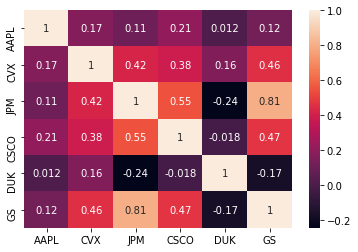

In [10]:
corr_matrix = np.corrcoef(np.vstack((data_predictors, data_targets)))

sns.heatmap(corr_matrix, annot=True, xticklabels=predictors + targets, yticklabels=predictors + targets)
plt.show()

## 4-5. Filtering, spectral density estimation

In [11]:
b1, a1 = signal.butter(3, 12, fs=365)
b2, a2 = signal.cheby1(4, 1, 12, fs=365)

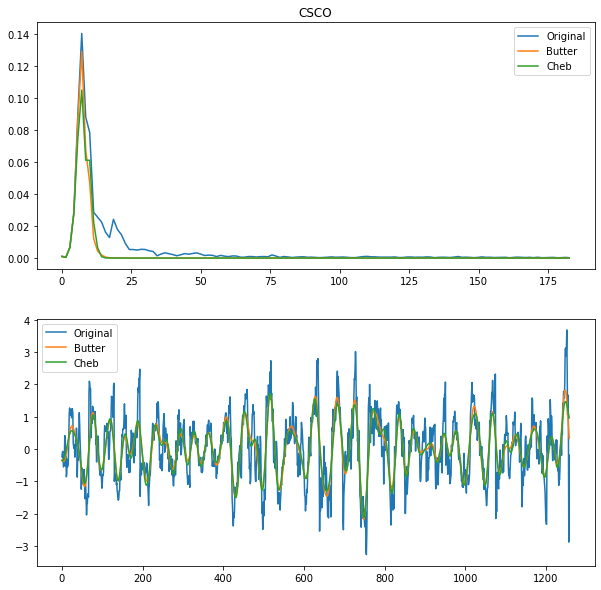

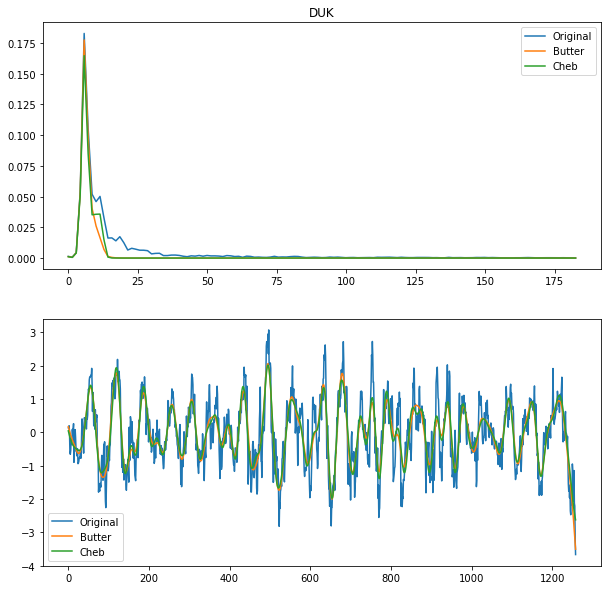

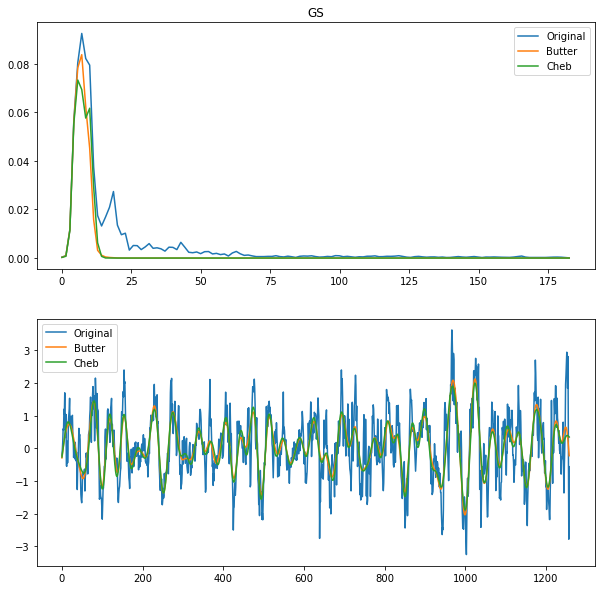

In [12]:
targets_filtered = []

for target, name in zip(data_targets, targets):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    ax1.set_title(name)
    f, spectrum_orig = signal.welch(target, fs=365)
    target_f1 = signal.filtfilt(b1, a1, target)
    target_f2 = signal.filtfilt(b2, a2, target)
    targets_filtered.append([target_f1, target_f2])
    _, spectrum_f1 = signal.welch(target_f1, fs=365)
    _, spectrum_f2 = signal.welch(target_f2, fs=365)
    ax1.plot(f, spectrum_orig, label='Original')
    ax1.plot(f, spectrum_f1, label='Butter')
    ax1.plot(f, spectrum_f2, label='Cheb')
    ax1.legend()
    ax1.plot()
    ax2.plot(target, label='Original')
    ax2.plot(target_f1, label='Butter')
    ax2.plot(target_f2, label='Cheb')
    ax2.legend()
    ax2.plot()

targets_filtered = np.array(targets_filtered)

## 6. Auto-regression

## Covariation analysis

In [13]:
for target, name in zip(data_targets, targets):
    plt.figure(figsize=(8, 4))
    plt.title(name)
    plt.plot(sm.stattools.acovf(target, nlag=240, fft=True))
    plt.show()

### As we can see, the autocorrelation function for targets have periodicity with period ~ 60 days, hence we fix the period of seasonal component and perform grid search over the remaining parameters

## Model selection

In [277]:
N = 200
train = data_targets[0][:N]
len_train = len(train)
M = 100
test = data_targets[0][N:N + M]
len_test = len(test)

In [278]:
ps = range(0, 6)
d = 1
qs = range(0, 6)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ('Models to analyse:', len(parameters_list))

results = []
best_mse = np.inf

warnings.filterwarnings('ignore')

for param in tqdm_notebook(parameters_list):
    try:
        model = SARIMAX(train, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 60), enforce_stationarity=False).fit()
        pred = model.predict(start=len_train, end=len_train + len_test - 1)
        mse = mean_squared_error(test, pred)
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_param = param
            best_pred = pred
        results.append([param, mse])
    except Exception as e:
        print(e)

Models to analyse: 72


  0%|          | 0/72 [00:00<?, ?it/s]

In [279]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'mse']
print(result_table.sort_values(by='mse', ascending=True).head())

      parameters       mse
65  (5, 2, 1, 0)  1.321861
69  (5, 4, 1, 0)  1.322333
67  (5, 3, 1, 0)  1.322461
23  (1, 5, 1, 0)  1.324920
35  (2, 5, 1, 0)  1.342218


In [280]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  200
Model:             SARIMAX(5, 1, 2)x(1, 1, [], 31)   Log Likelihood                -128.379
Date:                             Tue, 20 Apr 2021   AIC                            274.758
Time:                                     00:14:37   BIC                            300.703
Sample:                                          0   HQIC                           285.301
                                             - 200                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1089      0.129      0.847      0.397      -0.143       0.361
ar.L2          0.5666      

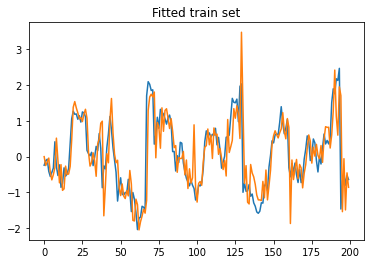

In [281]:
plt.title('Fitted train set')
plt.plot(train)
plt.plot(best_model.fittedvalues)
plt.show()

In [282]:
plt.title('Predictions on test set')
plt.plot(best_pred)
plt.plot(test)
plt.show()

## Fitted autoregressions for non-filtered targets

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  200
Model:             SARIMAX(4, 1, 5)x(1, 1, [], 60)   Log Likelihood                -149.833
Date:                             Tue, 20 Apr 2021   AIC                            321.665
Time:                                     00:23:11   BIC                            353.945
Sample:                                          0   HQIC                           334.783
                                             - 200                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2934      2.015      0.146      0.884      -3.656       4.243
ar.L2          0.0990      

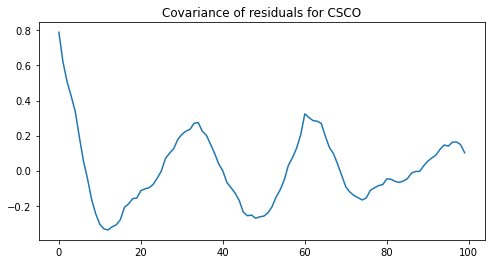

Max p-value of white noise test for residuals among all possible lags: 4.131e-29
---------------------------------------------------------------------------------------------
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  200
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 60)   Log Likelihood                -113.498
Date:                             Tue, 20 Apr 2021   AIC                            240.996
Time:                                     00:23:23   BIC                            261.538
Sample:                                          0   HQIC                           249.344
                                             - 200                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

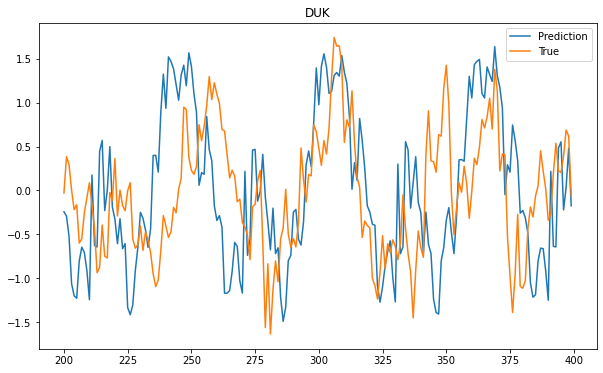

Max p-value of white noise test for residuals among all possible lags: 6.204e-29
---------------------------------------------------------------------------------------------
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  200
Model:             SARIMAX(2, 1, 5)x(1, 1, [], 60)   Log Likelihood                -124.475
Date:                             Tue, 20 Apr 2021   AIC                            266.949
Time:                                     00:23:59   BIC                            293.359
Sample:                                          0   HQIC                           277.682
                                             - 200                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

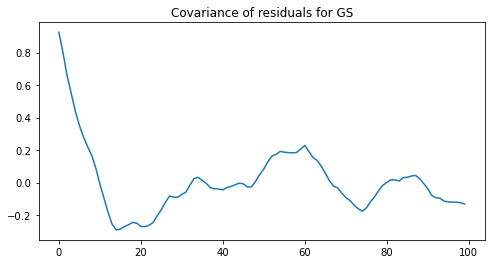

Max p-value of white noise test for residuals among all possible lags: 6.186e-35
---------------------------------------------------------------------------------------------


In [284]:
N = 200
best_params_for_models = [(4, 5, 1, 0), (3, 3, 0, 0), (2, 5, 1, 0)]

for target, name, param in zip(data_targets, targets, best_params_for_models):
    train = target[:N]
    len_train = len(train)
    test = target[N:2 * N]
    len_test = len(test)
    model = SARIMAX(train, order=(param[0], 1, param[1]), seasonal_order=(param[2], 1, param[3], 60)).fit()
    print(model.summary())
    pred = model.predict(start=len_train, end=len_train + len_test - 1)
    print(name)
    print(f'MSE = {mean_squared_error(test, pred)}')
    print(f'MAE = {mean_absolute_error(test, pred)}')
    print(f'R^2 = {r2_score(test, pred)}')
    plt.figure(figsize=(10, 6))
    plt.title(name)
    plt.plot(np.arange(len_train, len_train + len_test), pred, label='Prediction')
    plt.plot(np.arange(len_train, len_train + len_test), test, label='True')
    plt.legend()
    plt.plot()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.title(f'Covariance of residuals for {name}')
    plt.plot(sm.stattools.acovf(test - pred, nlag=M - 1, fft=True))
    plt.show()
    
    _, p_values = acorr_ljungbox(test - pred, lags=M - 1)
    print(f'Max p-value of white noise test for residuals among all possible lags: {np.max(p_values):.3e}')
    print(f'---------------------------------------------------------------------------------------------')

### We see that even for the best fitted auto-regressions, the residuals still has some of the original signal periodicity.

## For filtered data, it seems that differencing is not required, as we was able to obtain better fit without it.

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(3, 0, 4)x(1, 0, [], 31)   Log Likelihood                2041.539
Date:                             Tue, 20 Apr 2021   AIC                          -4065.077
Time:                                     00:29:06   BIC                          -4032.826
Sample:                                          0   HQIC                         -4052.121
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.8396      0.001   4939.453      0.000       2.838       2.841
ar.L2         -2.7131   7.2

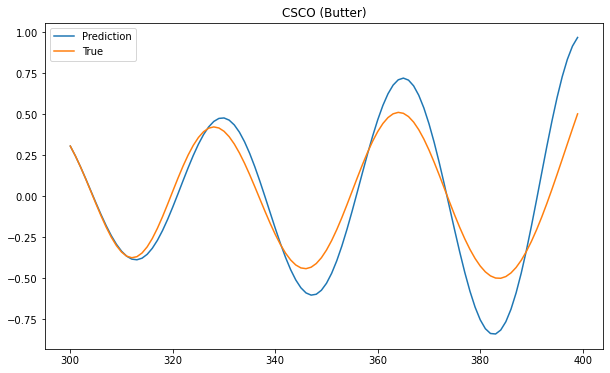

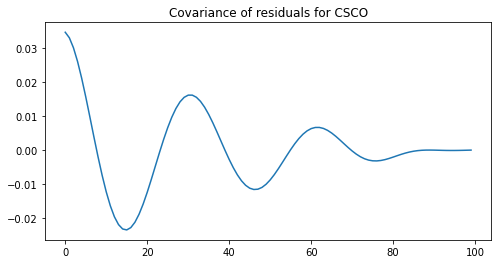

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(3, 0, 4)x(1, 0, [], 31)   Log Likelihood                2132.225
Date:                             Tue, 20 Apr 2021   AIC                          -4246.449
Time:                                     00:29:12   BIC                          -4214.198
Sample:                                          0   HQIC                         -4233.493
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.8435      0.001   3100.926      0.000       2.842       2.845
ar.L2         -2.7192      

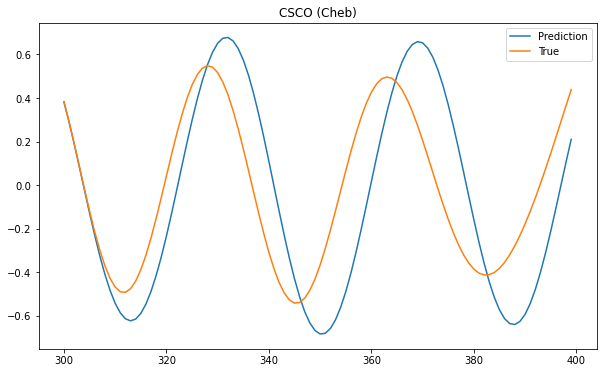

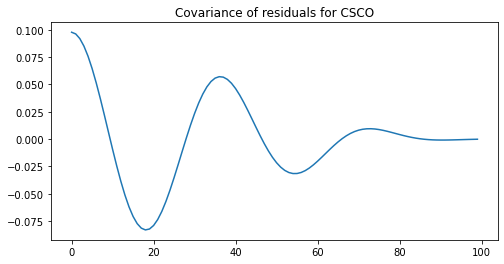

Max p-value of white noise test for residuals among all possible lags: 1.683e-23
---------------------------------------------------------------------------------------------
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(5, 0, 4)x(1, 0, [], 31)   Log Likelihood                2269.056
Date:                             Tue, 20 Apr 2021   AIC                          -4516.112
Time:                                     00:29:14   BIC                          -4476.777
Sample:                                          0   HQIC                         -4500.306
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

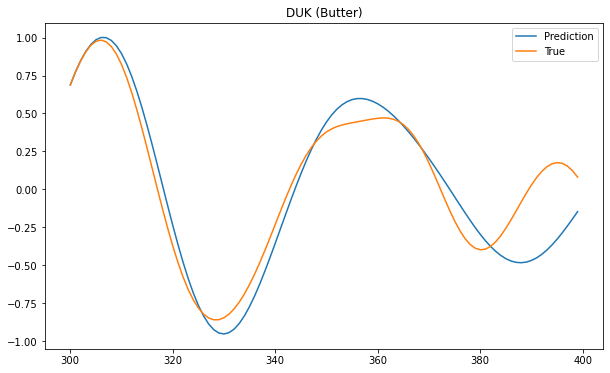

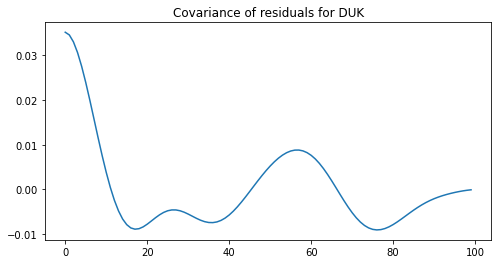

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(5, 0, 4)x(1, 0, [], 31)   Log Likelihood                2620.750
Date:                             Tue, 20 Apr 2021   AIC                          -5219.499
Time:                                     00:29:15   BIC                          -5180.164
Sample:                                          0   HQIC                         -5203.693
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          4.9451      0.000   1.59e+04      0.000       4.944       4.946
ar.L2         -9.8278      

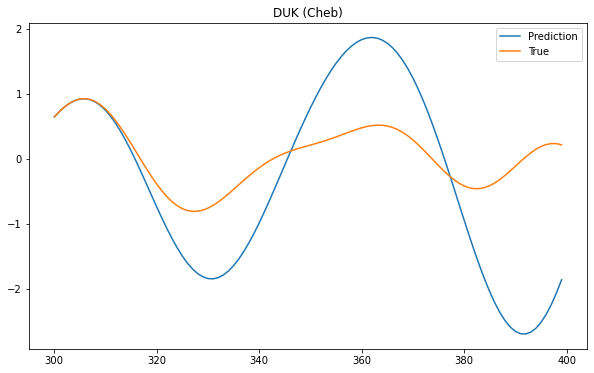

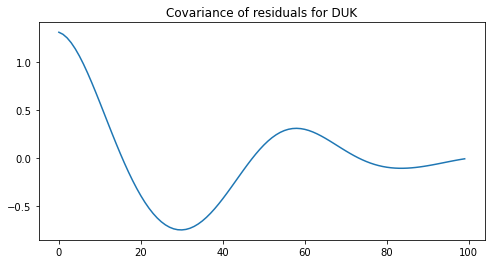

Max p-value of white noise test for residuals among all possible lags: 1.785e-23
---------------------------------------------------------------------------------------------
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(0, 0, 5)x(1, 0, [], 31)   Log Likelihood                 576.967
Date:                             Tue, 20 Apr 2021   AIC                          -1139.934
Time:                                     00:29:25   BIC                          -1114.771
Sample:                                          0   HQIC                         -1129.829
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

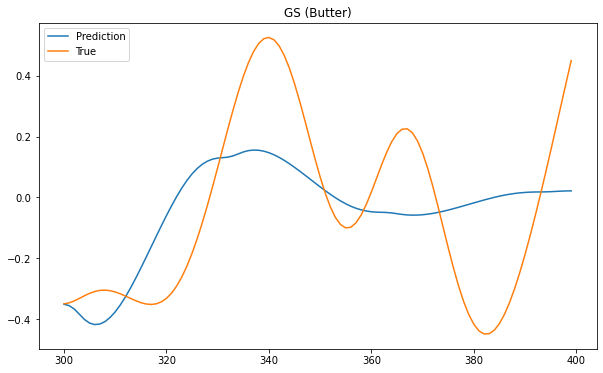

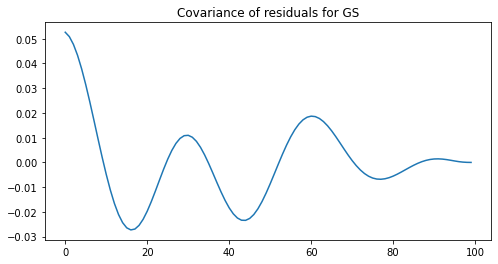

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(0, 0, 5)x(1, 0, [], 31)   Log Likelihood                 593.984
Date:                             Tue, 20 Apr 2021   AIC                          -1173.968
Time:                                     00:29:30   BIC                          -1148.805
Sample:                                          0   HQIC                         -1163.863
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          4.5429      0.275     16.546      0.000       4.005       5.081
ma.L2          8.6039      

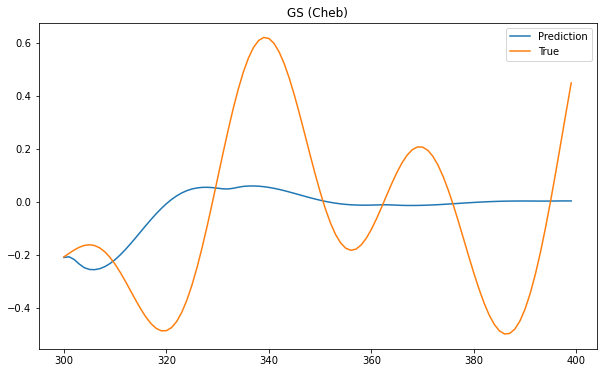

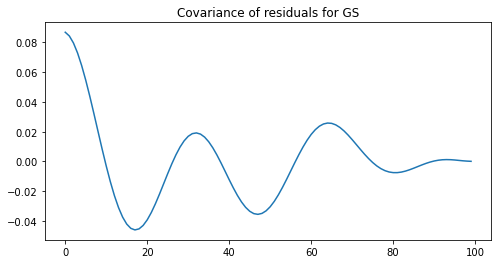

Max p-value of white noise test for residuals among all possible lags: 6.361e-23
---------------------------------------------------------------------------------------------


In [285]:
N = 300
M = 100
best_params_for_models = [(3, 4, 1, 0), (5, 4, 1, 0), (0, 5, 1, 0)]

for targets, name, param in zip(targets_filtered[:, :, :], targets, best_params_for_models):
    for target, filter_name in zip(targets, ['Butter', 'Cheb']):
        train = target[:N]
        len_train = len(train)
        test = target[N:N + M]
        len_test = len(test)
        model = SARIMAX(train, order=(param[0], 0, param[1]), seasonal_order=(param[2], 0, param[3], 31), enforce_stationarity=False).fit()
        print(model.summary())
        pred = model.predict(start=len_train, end=len_train + len_test - 1)
        print(f'{name} ({filter_name})')
        print(f'MSE = {mean_squared_error(test, pred)}')
        print(f'MAE = {mean_absolute_error(test, pred)}')
        print(f'R^2 = {r2_score(test, pred)}')
        plt.figure(figsize=(10, 6))
        plt.title(f'{name} ({filter_name})')
        plt.plot(np.arange(len_train, len_train + len_test), pred, label='Prediction')
        plt.plot(np.arange(len_train, len_train + len_test), test, label='True')
        plt.legend()
        plt.plot()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.title(f'Covariance of residuals for {name}')
        plt.plot(sm.stattools.acovf(test - pred, nlag=M - 1, fft=True))
        plt.show()
    
    _, p_values = acorr_ljungbox(test - pred, lags=M - 1)
    print(f'Max p-value of white noise test for residuals among all possible lags: {np.max(p_values):.3e}')
    print(f'---------------------------------------------------------------------------------------------')

### We see that it was easier for autoregressive models to fit filtered data, while the residuals still have original signal periodicity with much smaller amplidutes.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Apr, 2021
Time:                     23:30:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.24250
Nobs:                     299.000    HQIC:                  -5.39837
Log likelihood:          -429.180    FPE:                 0.00407710
AIC:                     -5.50239    Det(Omega_mle):      0.00380365
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.003670         0.027493           -0.133           0.894
exog0        -0.053542         0.038868           -1.378           0.168
exog1         0.082184         0.041088            2.000           0.045
exog2         0.153117

/home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


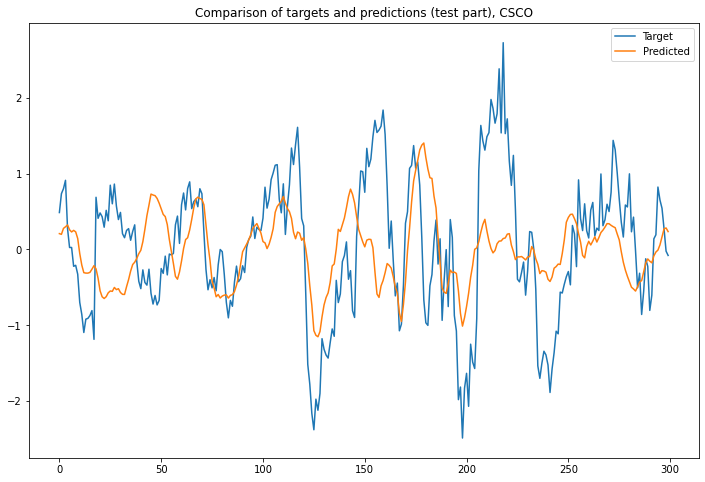

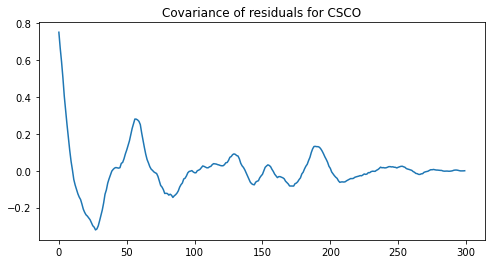

Max p-value of white noise test for residuals among all possible lags: 1.611e-53
---------------------------------------------------------------------------------------------
Company: DUK
MSE = 0.633308683090181
MAE = 0.6374243346216629
R^2 = 0.3995841376584708


/home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


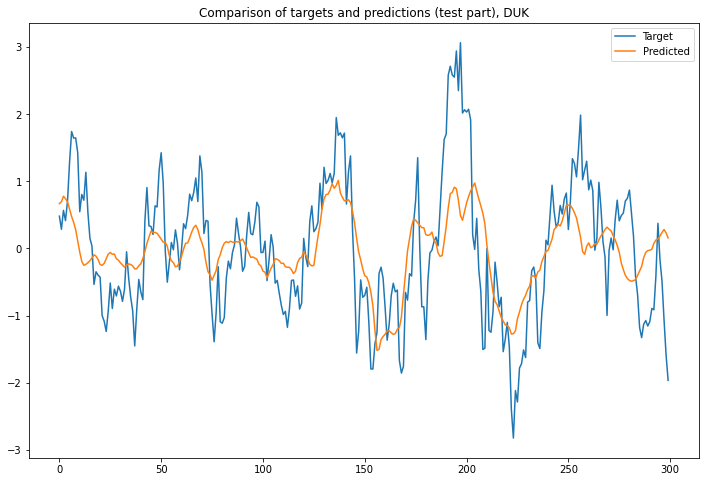

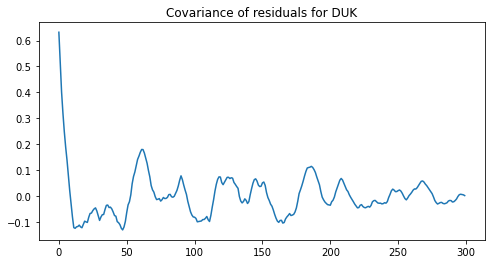

/home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Max p-value of white noise test for residuals among all possible lags: 6.180e-46
---------------------------------------------------------------------------------------------
Company: GS
MSE = 0.3153279468468376
MAE = 0.470153906143971
R^2 = 0.48677516484009187


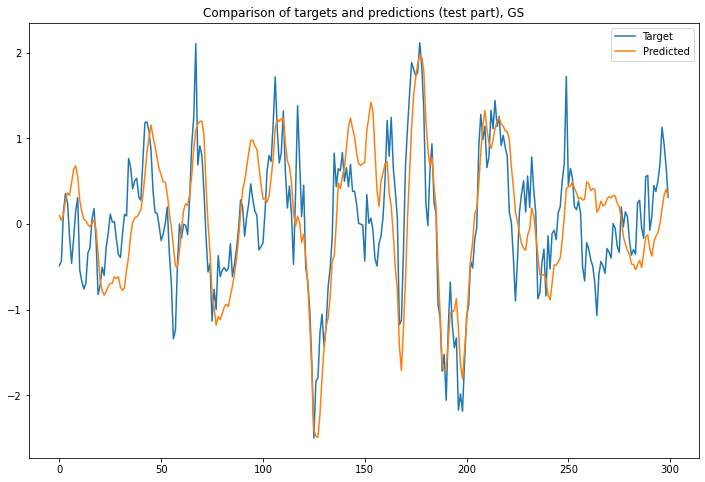

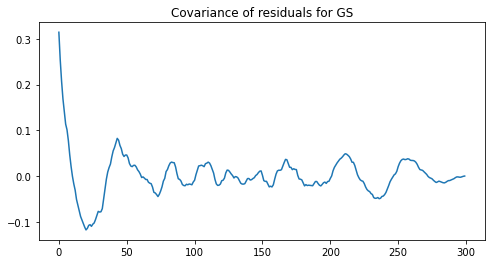

Max p-value of white noise test for residuals among all possible lags: 5.280e-45
---------------------------------------------------------------------------------------------


/home/yakov/anaconda3/envs/ml-common/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [35]:
## 7. Linear dynamic system

### We see that even for the best forecast (GS) residuals have some periodicity of autocovariance function, and obtained p-values also indicating that the residuals are not white noise. However, increasing the order of model did not improve the prediction quality, as all the auto-regression coefficients but the last are set to zero.